# Introduction
In this small project we will take a look at Seattle weather dataset from Kaggle to extract important features and use them to test functionality of Recurrent Neural Network.
<br><br>
#### Main objective
Build a model using PyTorch library that predicts temperature for the next day.
<br><br>
#### Process includes:
1. **Data** <br>
&ensp;1.1 Overview <br>
&ensp;1.2 Anomalies <br>
&ensp;1.3 Visualization <br>
&ensp;1.4 Preparing data for model <br>
2. **Building model** <br>
&ensp;2.1 Train / test split <br>
&ensp;2.2 Sequencing datasets <br>
&ensp;2.3 Class LSTM <br>
&ensp;2.4 Training function <br>
&ensp;2.5 Testing function <br>
&ensp;2.6 Training and Testing the RNN models <br>
3. **Conclusion**

#### Setup
Matplotlib color scheme.

In [1]:
import matplotlib.pyplot as plt

WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

Random seeds, cuda and warnings.

In [2]:
import numpy as np
import torch
import random
import warnings

warnings.filterwarnings("ignore")

seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Load Data

In [3]:
import pandas as pd

df = pd.read_csv('../datasets/weather-processed.csv')
df

,precipitation,wind,temp_avg
0,0.0,4.7,8.90
1,10.9,4.5,6.70
2,0.8,2.3,9.45
3,20.3,4.7,8.90
4,1.3,6.1,5.85
...,...,...,...
1456,8.6,2.9,3.05
1457,1.5,1.3,3.35
1458,0.0,2.6,3.90
1459,0.0,3.4,2.30


#### Scale data
Using _**MinMaxScaler**_ from sklearn to scale our features.

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['precipitation', 'temp_avg', 'wind']

df.loc[:, features] = scaler.fit_transform(df[features]) # applying scaled features to numeric features

df.describe()

,precipitation,wind,temp_avg
count,1461.000000,1461.000000,1461.000000
mean,0.054194,0.312213,0.529080
std,0.119503,0.158003,0.196657
min,0.000000,0.000000,0.000000
25%,0.000000,0.197802,0.378689
50%,0.000000,0.285714,0.516393
75%,0.050089,0.395604,0.688525
max,1.000000,1.000000,1.000000


#### Train / test split

In [5]:
train_size = int(len(df) * 0.7) + 1
test_size = int(len(df) * 0.3)

print(
    f"{f"train size":>12}: {train_size}",
    f"{f"test size":>12}: {test_size}",
    len(df) == train_size + test_size,
    sep='\n'
)

  train size: 1023
   test size: 438
True


In [6]:
df_train = df[:train_size]
df_test = df[train_size:]

We're going to pass sequenced data with length of n days per sequence. <br>
Knowing that, we have to make sure that our datasets are divisible by n. <br><br>
With _sequence_len_ parameter we can adjust length of sequence in days (1 day, week, month) and test how it affects models predictions. <br>
Despite this there's no enough data to test this model on longer sequences like month, so I chose one week.

In [7]:
sequence_len = 7

df_train = df_train[:(len(df_train) // sequence_len) * sequence_len]
df_test = df_test[:(len(df_test) // sequence_len) * sequence_len]

print(
    len(df_train),
    len(df_test), sep='\n'
)

1022
434


Convert each data split to numpy, so we're able to pass it to torch.

In [8]:
df_train_torch = df_train.to_numpy()
df_train_torch = torch.tensor(df_train_torch)

df_test_torch = df_test.to_numpy()
df_test_torch = torch.tensor(df_test_torch)
df_test_torch[:7]

tensor([[0.2093, 0.2967, 0.5885],
        [0.0179, 0.4725, 0.5803],
        [0.5725, 0.5055, 0.5721],
        [0.1682, 0.4615, 0.4967],
        [0.0733, 0.3077, 0.5066],
        [0.1091, 0.5495, 0.5344],
        [0.0268, 0.5055, 0.4623]], dtype=torch.float64)

#### 2.2 - Data loader
To predict temperature based on features from past n days, <br>
we have to reshape our data split sets to return specific sequences. <br><br>
Each sequence containing data from 7 days, where: <br>
X - temp_avg from first n days <br>
y - same feature, but we take just the last day

In [9]:
from torch.utils.data import TensorDataset, DataLoader

def sequence_dataset(dataset, batch_size, extra_features=False):
    
    x, y = [], []
    
    for i in range(0, len(dataset) - sequence_len, sequence_len):
        
        # if extra_features = True, then x = [precipitation, wind, temp_avg], y = temp_avg
        # if extra_features = False, then x = temp_avg, y = temp_avg
        if extra_features:
            week = dataset[i: i + sequence_len, :] # take precipitation, wind and temperature (:)
            week_input = week[:sequence_len-1] # trim to n days
            week_target = week[-1, 2] # take last day
        else:
            week = dataset[i: i + sequence_len, 2] # take just the temperature (2)
            week_input = week[:sequence_len-1] # trim to n days
            week_target = week[-1] # take last day
        
        x.append(week_input)
        y.append(week_target)
        
    # covert to tensor dataset
    tensor_dataset = TensorDataset(torch.tensor(np.asarray(x)),
                                   torch.tensor(np.asarray(y)))
    
    # covert to data_loader
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return data_loader

In [10]:
batch_size = 8
train_loader = sequence_dataset(df_train_torch, batch_size=batch_size)
test_loader = sequence_dataset(df_test_torch, batch_size=batch_size)

In [11]:
df_train[:7]

,precipitation,wind,temp_avg
0,0.000000,0.472527,0.416393
1,0.194991,0.450549,0.344262
2,0.014311,0.208791,0.434426
3,0.363148,0.472527,0.416393
4,0.023256,0.626374,0.316393
5,0.044723,0.197802,0.232787
6,0.000000,0.208791,0.288525


In [12]:
i = 0
for batch in train_loader:
    if i == 0:
        input, target = batch
        print(input, target)
        # print(input.size())
        # print(target.size())
        # print(len(target))
        break
    i += 1

tensor([[0.3344, 0.3803, 0.3623, 0.3787, 0.3246, 0.2885],
        [0.8344, 0.8721, 0.8721, 0.8426, 0.9180, 0.8443],
        [0.2885, 0.2066, 0.1361, 0.0262, 0.0000, 0.0984],
        [0.4066, 0.4803, 0.4623, 0.3984, 0.4344, 0.4344],
        [0.4066, 0.4607, 0.6885, 0.7344, 0.7885, 0.5984],
        [0.2525, 0.2443, 0.3426, 0.4066, 0.3705, 0.4705],
        [0.7066, 0.6885, 0.6525, 0.6984, 0.6803, 0.5623],
        [0.4344, 0.4705, 0.4803, 0.5705, 0.5902, 0.5984]], dtype=torch.float64) tensor([0.3066, 0.8623, 0.2082, 0.4344, 0.5164, 0.4787, 0.6082, 0.5262],
       dtype=torch.float64)


In [13]:
for batch in train_loader:
    input, target = batch
    print(input[0], target[0], sep='\n')
    break

tensor([0.6705, 0.7344, 0.6984, 0.7164, 0.7082, 0.6623], dtype=torch.float64)
tensor(0.6541, dtype=torch.float64)


#### 2.3 class LSTM
With PyTorch we are able to build simple RNN with Long Short-Term Memory layers by simply attaching _nn.LSTM()_ with specific factors in it. <br>
The __init__ function first initializes the LSTM and fully connected layers. <br>
__*forward()*__ passes our input x to the rnn network then fully connects it to finally return last value from the output.

In [14]:
from torch import nn

class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3, n_layers=2, dropout=0):
        super(WeatherRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) # take the last hidden
        return out

#### 2.4 Training function
So we take our train_loader and pass it to our training function. <br>
Training function iterates over batches for n_epoch times and passes sequences from these batches to our model <br>
that calculates loss by comparing calculated outputs with actual targets using Mean Squared Error function.

In [15]:
import torch.optim as optim
import copy

def train_model(model, device, train_loader, n_epochs=1, lr=0.001, extra_features=False):
    
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss_history = []
    best_loss = float('inf')
    best_epoch = 0
    best_weights = copy.deepcopy(model.state_dict()) # init weights
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss = 0
        avg_loss = 0
        
        for i, batch in enumerate(train_loader):
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())
            
            if not extra_features:
                inputs = inputs.unsqueeze(-1)
            
            optimizer.zero_grad() # clean gradients
            outputs = model(inputs) # calculate outputs
            
            loss = criterion(outputs, targets.unsqueeze(1)) # add dim
            loss.backward() # backpropagation
            optimizer.step() # update weights

            epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
        
        # check if current epoch is the best one
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch - 1
            
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch} / {n_epochs} finished | {epoch_loss/len(train_loader):.4f}")
            
        loss_history.append(epoch_loss)
        
    model.load_state_dict(best_weights)
    
    return loss_history, best_epoch

In [20]:
input_size = 1
output_size = 1
hidden_size = 64
n_layers = 1
dropout = 0
learning_rate = 0.001
n_epochs = 30

weather_rnn = WeatherRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers, output_size=output_size, dropout=dropout)

loss_history, best_epoch = train_model(weather_rnn, device=device, train_loader=train_loader, n_epochs=n_epochs, lr=learning_rate)

Epoch 1 / 30 finished | 0.2917
Epoch 10 / 30 finished | 0.0075
Epoch 20 / 30 finished | 0.0070
Epoch 30 / 30 finished | 0.0077


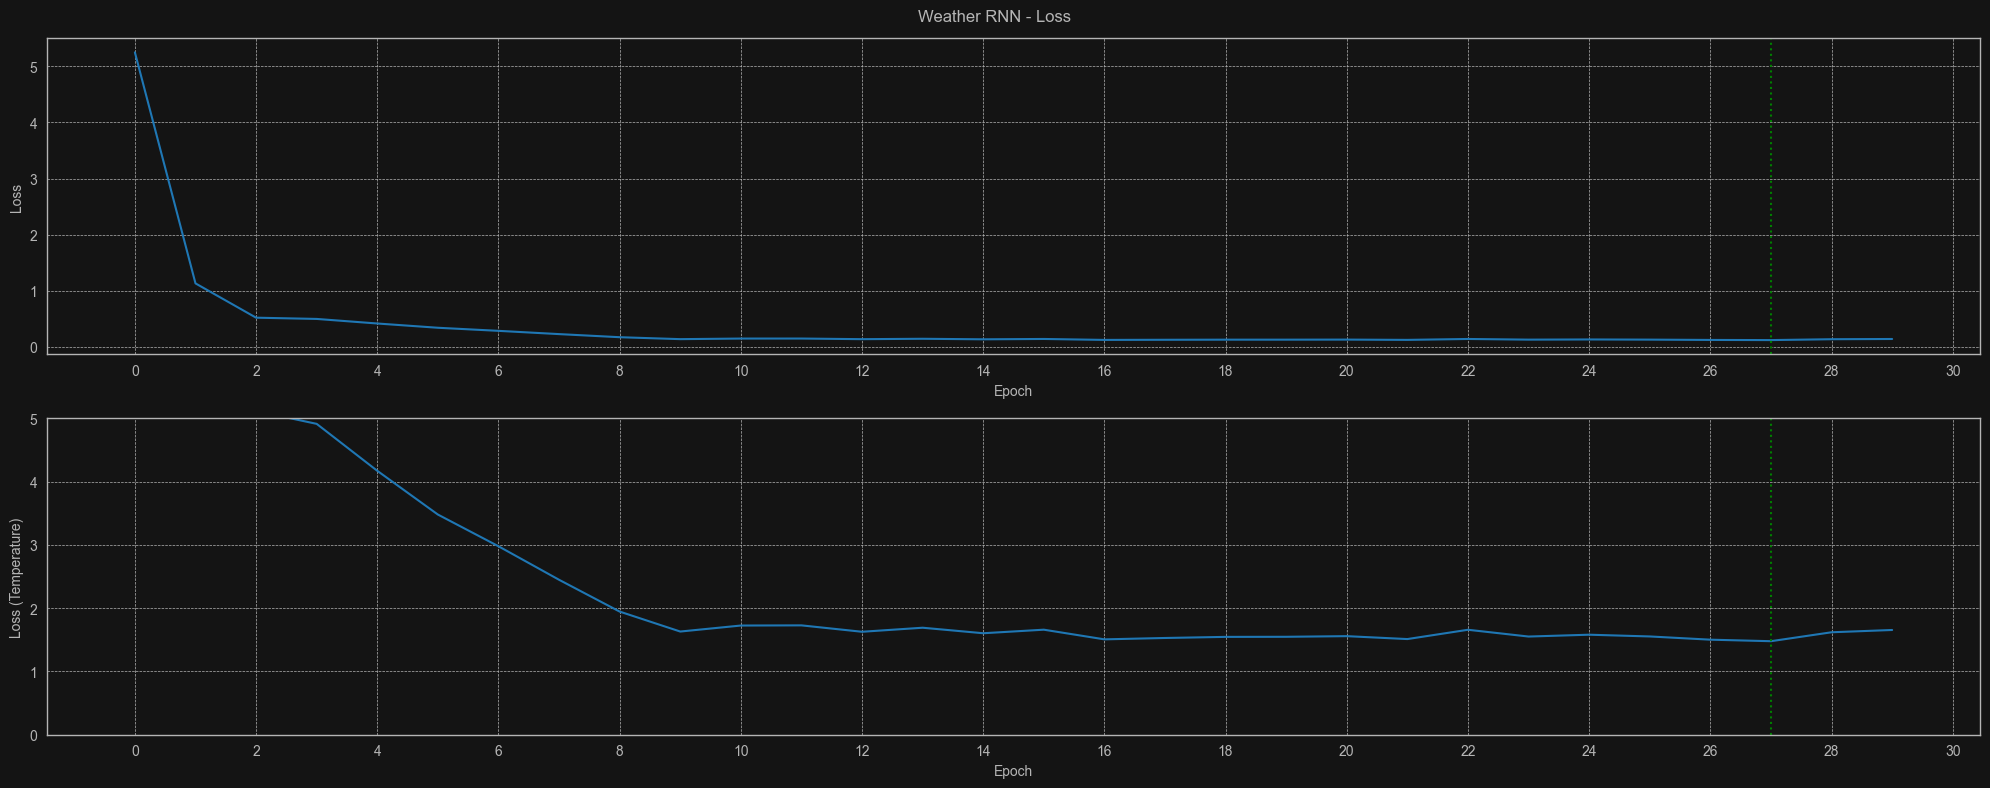

In [21]:
import seaborn as sb

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
axes = axes.flatten()

plt.suptitle('Weather RNN - Loss')

sb.lineplot(loss_history, ax=axes[0])
axes[0].set_xticks(range(0, n_epochs + 1, 2))
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].axvline(x=best_epoch, color='g', linestyle=':')

loss_history_rescaled = np.zeros((len(loss_history), 3))
loss_history_rescaled[:, 2] = np.array(loss_history)
loss_history_rescaled = scaler.inverse_transform(loss_history_rescaled)[:, 2]

sb.lineplot(loss_history_rescaled, ax=axes[1])
axes[1].set_xticks(range(0, n_epochs + 1, 2))
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (Temperature)')
axes[1].set_ylim((0, 5))
axes[1].axvline(x=best_epoch, color='g', linestyle=':')

plt.tight_layout()

#### 2.5 Testing function
Similar to training function. This time we run the model with no gradients calculations <br>
and iterate through batches from test_loader. <br>
Then return y true and y predicted values to compare where the model makes most mistakes.

In [22]:
def test_model(model, device, test_loader, extra_features=False):
    total_loss = 0
    criterion = nn.MSELoss()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())
            
            if not extra_features:
                inputs = inputs.unsqueeze(-1)

            outputs = model(inputs) # get outputs

            loss = criterion(outputs, targets.unsqueeze(1)) # add dim
            total_loss += loss.item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test MSE Loss: {avg_loss:.4f}")

    return y_true, y_pred

Test MSE Loss: 0.0086


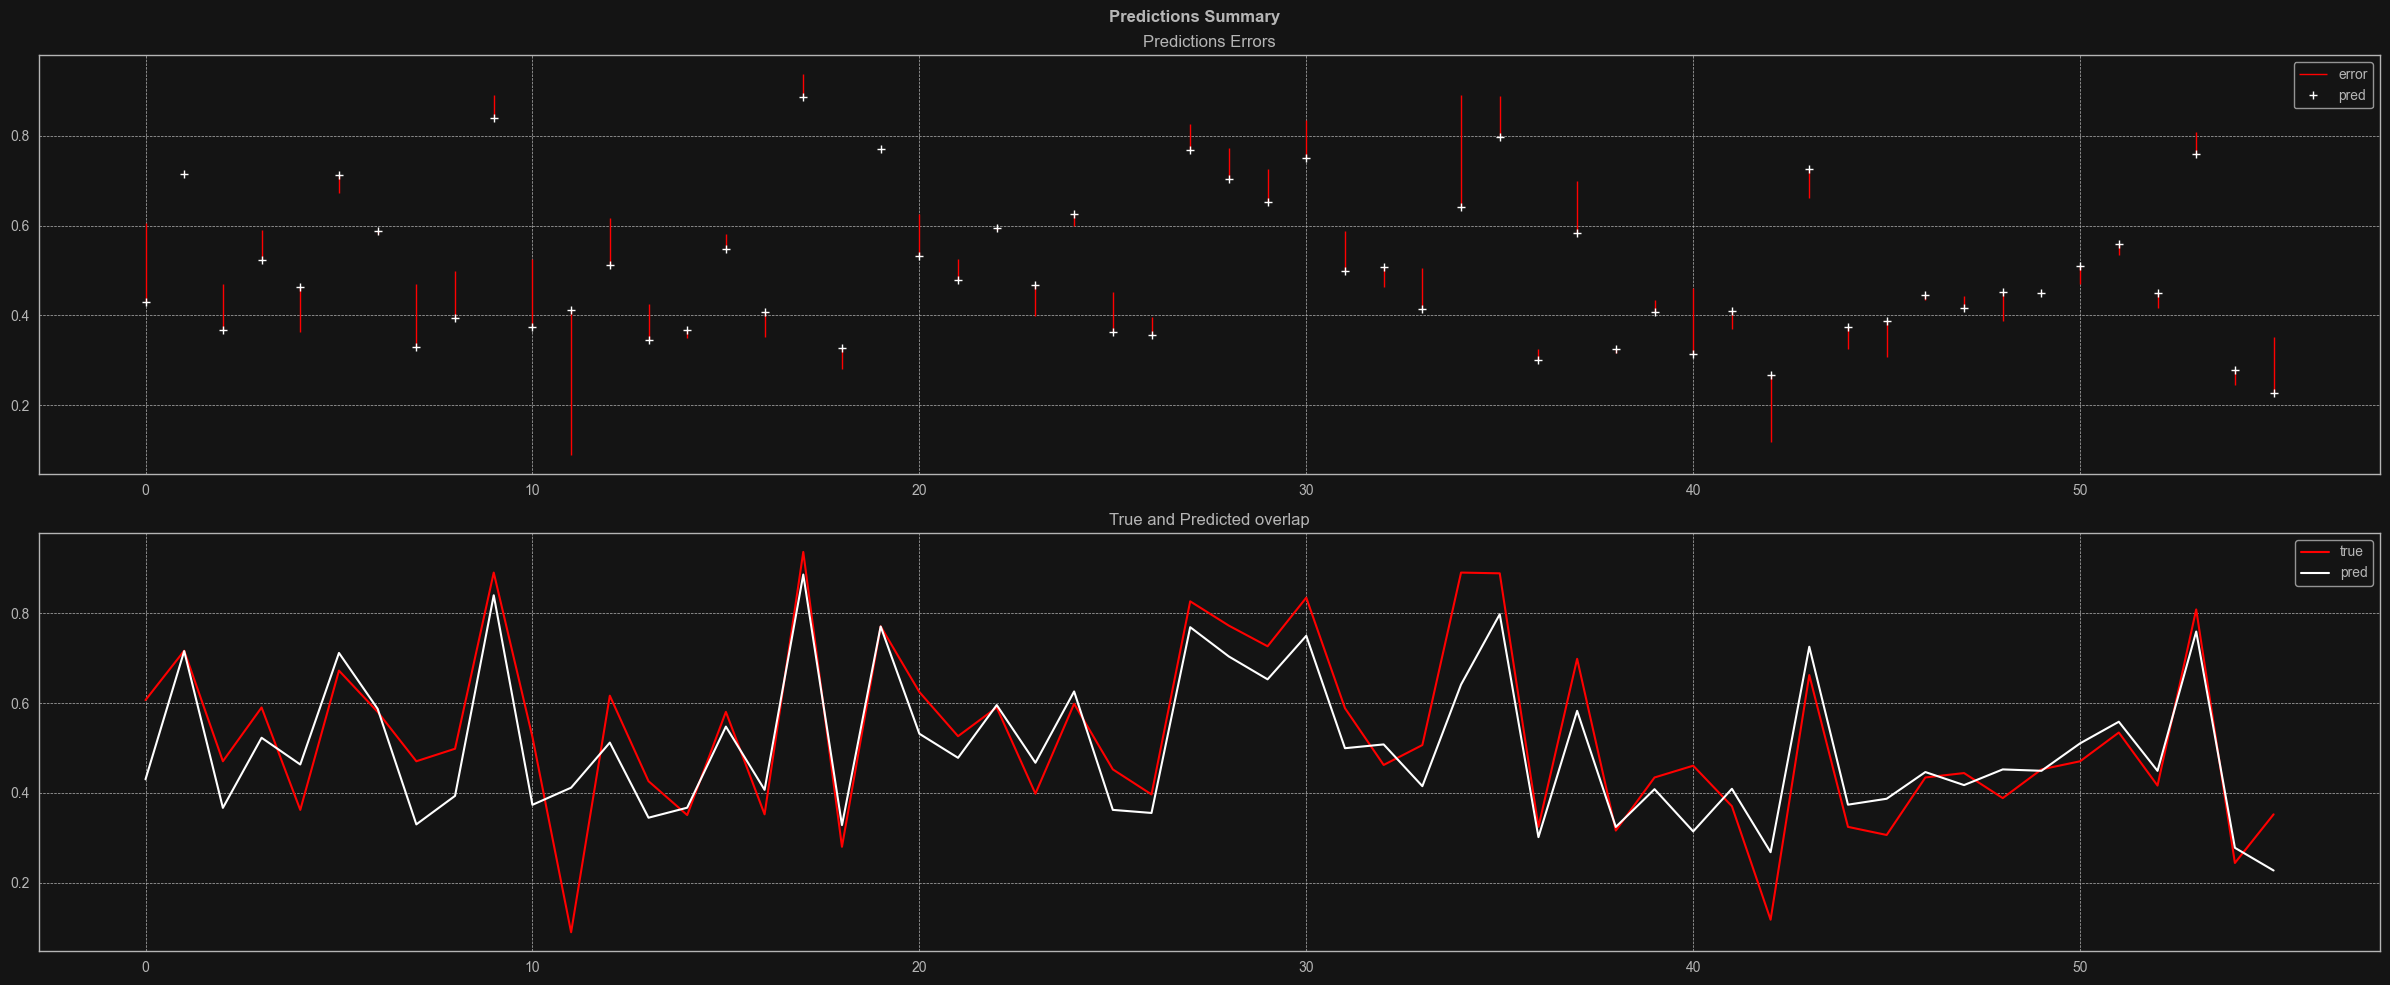

In [23]:
import seaborn as sb

y_true, y_pred = test_model(weather_rnn, device=device, test_loader=test_loader)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 10))
axes = axes.flatten()

temp_avg_true = np.array(y_true).flatten()
temp_avg_pred = np.array(y_pred).flatten()

x = range(len(temp_avg_true))
axes[0].vlines(x=x, ymin=temp_avg_pred, ymax=temp_avg_true, color='red', linewidth=1, label='error')
axes[0].plot(x, y_pred, marker='+', linestyle='None', color='white', label='pred')

sb.lineplot(x=range(len(temp_avg_true)), y=temp_avg_true, color='red', ax=axes[1], label='true')
sb.lineplot(x=range(len(temp_avg_pred)), y=temp_avg_pred, color='white', ax=axes[1], label='pred')

axes[0].set_title('Predictions Errors')
axes[0].legend()

axes[1].set_title('True and Predicted overlap')

plt.suptitle('Predictions Summary', fontweight='bold')
plt.tight_layout()

In [24]:
from scipy.stats import mode

true_deg = np.zeros((len(temp_avg_true), 3))
pred_deg = np.zeros((len(temp_avg_pred), 3))

true_deg[:, 2] = np.sqrt(temp_avg_true)
pred_deg[:, 2] = np.sqrt(temp_avg_pred)

true_deg = scaler.inverse_transform(true_deg)
pred_deg = scaler.inverse_transform(pred_deg)

error = abs(true_deg - pred_deg)

print(
    f"{"mean":>6}: {error.mean()}",
    f"{"mode":>6}: {mode(error)[0][2]}",
    f"{"max":>6}: {error.max()}",
    f"{"min":>6}: {error.min()}",
    f"{"range":>6}: {true_deg.max() - true_deg.min()}",
    sep='\n'
)

  mean: 0.16366088936726256
  mode: 0.0011585712432857775
   max: 3.1068338125944135
   min: 0.0
 range: 13.004293674230578


# III - Model with multiple features
#### 3.1 - Training function 2

In [25]:
train_loader_2 = sequence_dataset(df_train_torch, batch_size=batch_size, extra_features=True)
test_loader_2 = sequence_dataset(df_test_torch, batch_size=batch_size, extra_features=True)

In [26]:
i = 0
for batch in train_loader_2:
    if i == 0:
        input, target = batch
        # print(input, target)
        print(input.size())
        print(target.size())
        break
    i += 1

torch.Size([8, 6, 3])
torch.Size([8])


In [27]:
weather_rnn_2 = WeatherRNN(input_size=3,
                           hidden_size=64,
                           n_layers=1,
                           output_size=1,
                           dropout=0)

loss_history_2, best_epoch_2 = train_model(weather_rnn_2, device=device, train_loader=train_loader_2, n_epochs=n_epochs, lr=0.001, extra_features=True)

Epoch 1 / 30 finished | 0.2538
Epoch 10 / 30 finished | 0.0081
Epoch 20 / 30 finished | 0.0068
Epoch 30 / 30 finished | 0.0067


Test MSE Loss: 0.0073


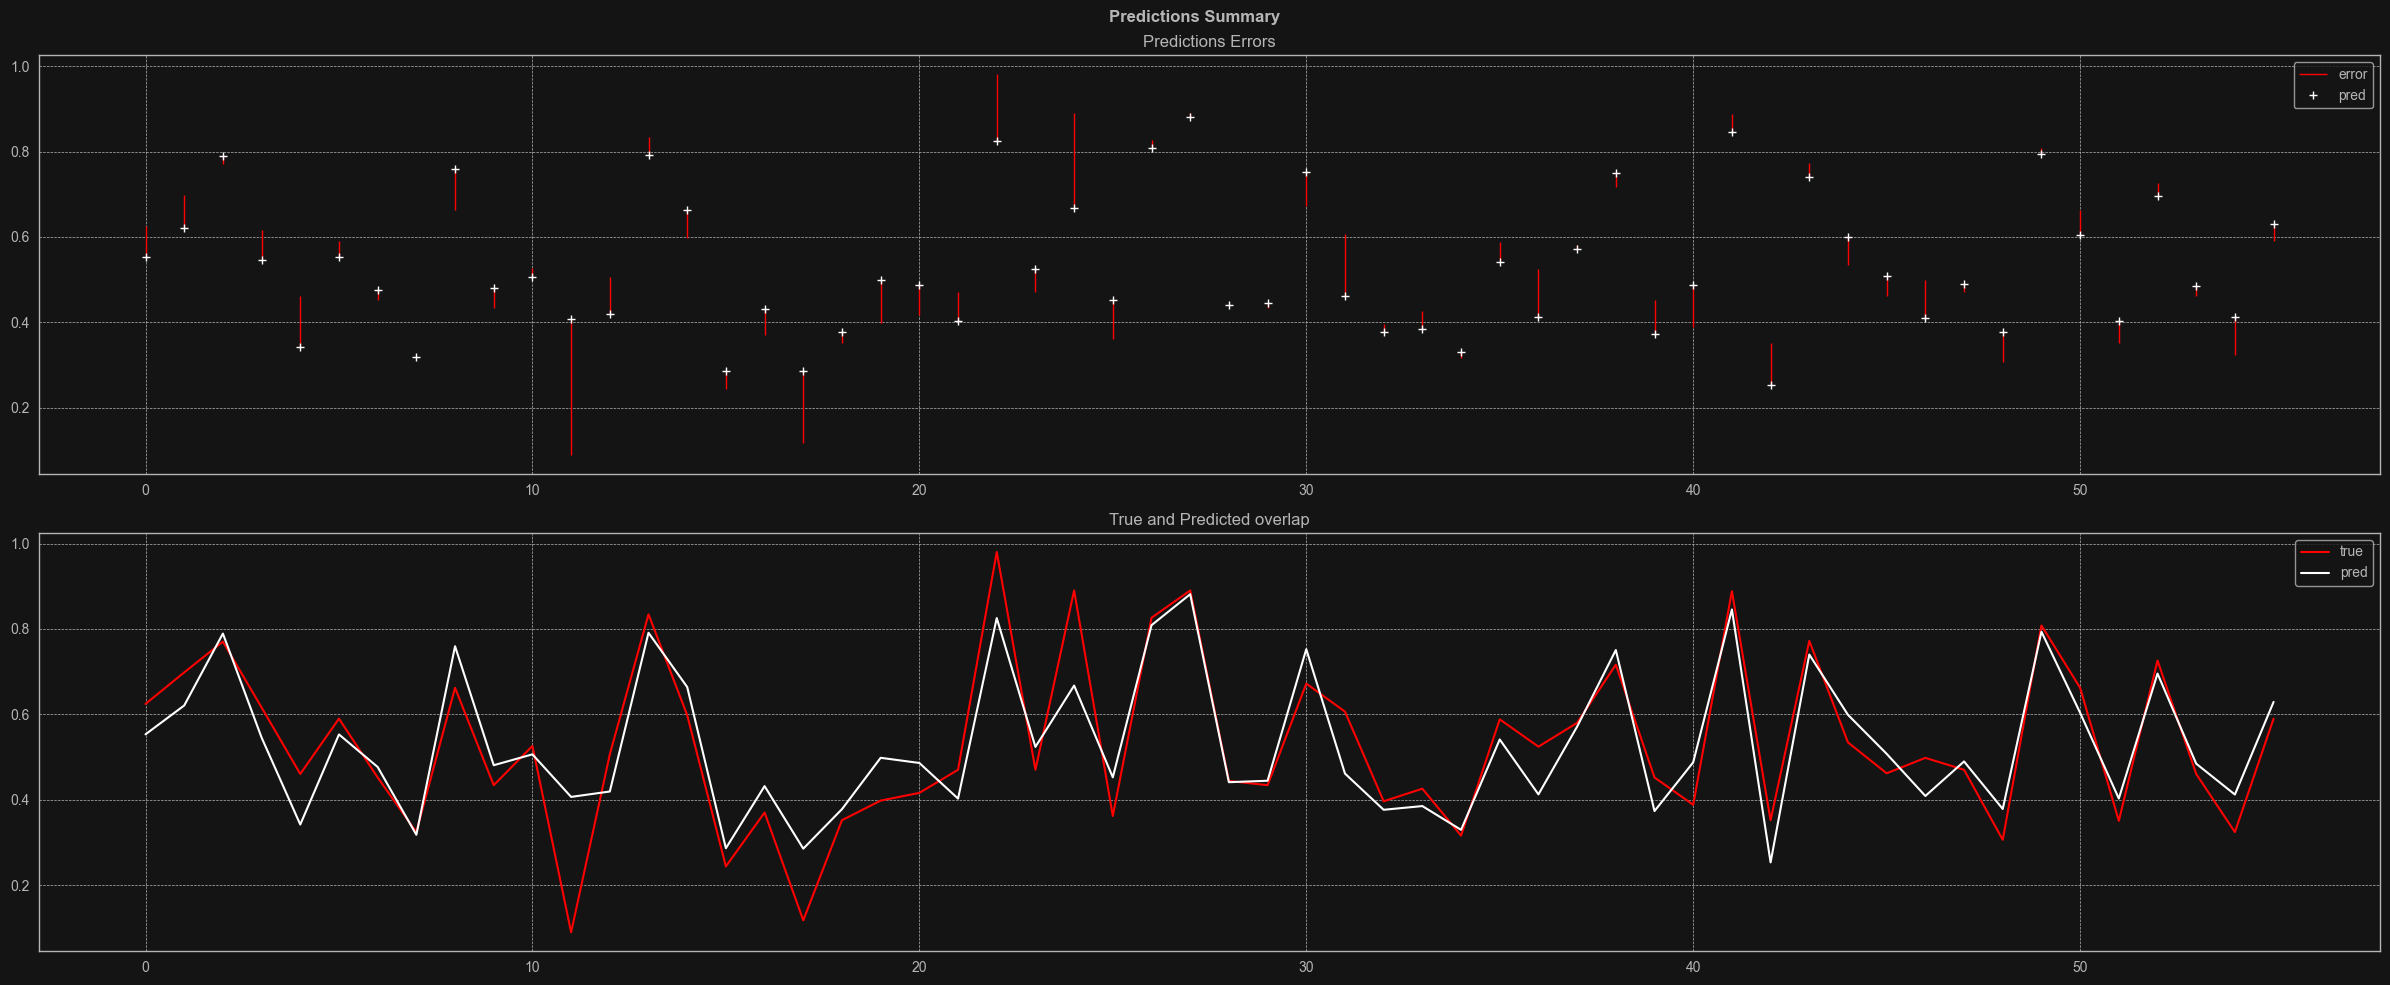

In [28]:
y_true_2, y_pred_2 = test_model(weather_rnn_2, device=device, test_loader=test_loader_2, extra_features=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 10))
axes = axes.flatten()

temp_avg_true_2 = np.array(y_true_2).flatten()
temp_avg_pred_2 = np.array(y_pred_2).flatten()

x = range(len(temp_avg_true_2))
axes[0].vlines(x=x, ymin=temp_avg_pred_2, ymax=temp_avg_true_2, color='red', linewidth=1, label='error')
axes[0].plot(x, y_pred_2, marker='+', linestyle='None', color='white', label='pred')

sb.lineplot(x=range(len(temp_avg_true_2)), y=temp_avg_true_2, color='red', ax=axes[1], label='true')
sb.lineplot(x=range(len(temp_avg_pred_2)), y=temp_avg_pred_2, color='white', ax=axes[1], label='pred')

axes[0].set_title('Predictions Errors')
axes[0].legend()

axes[1].set_title('True and Predicted overlap')

plt.suptitle('Predictions Summary', fontweight='bold')
plt.tight_layout()

In [29]:
from scipy.stats import mode

true_deg_2 = np.zeros((len(temp_avg_true_2), 3))
pred_deg_2 = np.zeros((len(temp_avg_pred_2), 3))

true_deg_2[:, 2] = np.sqrt(temp_avg_true_2)
pred_deg_2[:, 2] = np.sqrt(temp_avg_pred_2)

true_deg_2 = scaler.inverse_transform(true_deg_2)
pred_deg_2 = scaler.inverse_transform(pred_deg_2)

error = abs(true_deg_2 - pred_deg_2)

print(
    f"{"mean":>6}: {error.mean()}",
    f"{"mode":>6}: {mode(error)[0][2]}",
    f"{"max":>6}: {error.max()}",
    f"{"min":>6}: {error.min()}",
    f"{"range":>6}: {true_deg_2.max() - true_deg_2.min()}",
    sep='\n'
)

  mean: 0.14840225962301096
  mode: 0.019484174251555686
   max: 3.072875091433524
   min: 0.0
 range: 13.210046923160554


# III - Conclusion
Clearly the model doesn't see any value in the chaos that is in the _precipitation_ and _wind_ series. <br>
Despite this fact the model did decent job with predicting average temperature, both for weekly and daily sequences. <br><br>
Overall I think this project gives quiet simple fundamentals to understand the functionality of Recurrent Neural Networks.
#### Thanks for reading my project, I hope you enjoyed the process :]
_Gracjan Pawłowski 2025_